# Data2Vec train

## Prep
---
### Libraries

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import glob
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datasets import load_dataset, Audio
import datasets
from transformers import AutoProcessor, Data2VecAudioModel
from transformers import AutoTokenizer, Data2VecTextModel

/home/arplab/project/gc/multi_modal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions
- `data_path`
- `make_audio_datasets`
- `make_text_datasets`
- `audio_embedding`
- `text_embedding`
- `make_target_dataframe`
- `make_target_dict`

- `tensor_fusion`

In [3]:
def data_path(session_num, modal):
# modal : wav, txt 둘 중 하나 입력
# 이렇게 불러온 데이터는 시간 순은 아님을 유의
    if session_num <= 9:
        dir_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/Session0' + str(session_num)
    else:
        dir_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/Session' + str(session_num)
    data_path = glob.glob(dir_path + '/*.' + modal)
    data_path = sorted(data_path)
    return data_path

def make_audio_datasets(num_sessions):
# num_sessions : from 1 to 40
# type(return) = dict{1:audio_dataset,...,40:audio_dataset}
    audio_datasets = {}
    
    for i in tqdm(range(1, num_sessions + 1)):
        # audio_datasets[i] = datasets.Dataset.from_dict({'audio': data_path(i, 'wav')})
        audio_datasets[i] = datasets.Dataset.from_dict({'audio': data_path(i, 'wav')}).cast_column("audio", Audio())
    return audio_datasets

def make_text_datasets(num_sessions):
# num_sessions : from 1 to 40
# type(return) = dict{1:[paths, corpus],...,40:[paths, corpus]}
    text_datasets = {}
    
    for i in tqdm(range(1, num_sessions + 1)):
        
        paths = []
        corpus = []
        
        for path in data_path(i, 'txt'):
            paths.append(path)
            with open(path, "r") as f:
                corpus.append(f.read())
        
        text_datasets[i] = [paths, corpus]

    return text_datasets  

def audio_embedding(audio_datasets, batch_size=32):
# audio_datasets = {1:audio_dataset, ... , 40:audio_dataset}
    batch_size = batch_size
    
    audio_processed_dict = {}
    for session, audio_dataset in audio_datasets.items():
        
        processed_audio_by_session = []
        for i in range(0, audio_dataset.num_rows, batch_size):
            
            audio_arrayes = []
            for j in audio_dataset[i:i+batch_size]['audio']:
                audio_arrayes.append(j['array'])
        
            inputs = processor(audio_arrayes, sampling_rate = sampling_rate,  padding=True, max_length=16000, truncation = True,return_attention_mask=True, return_tensors="pt")
            processed_audio_by_session.append(inputs)
        
        audio_processed_dict[session] = processed_audio_by_session

    
# audio_processed_dict : {1 : [[batch 당 processing][batch 당 processing][batch 당 processing]],2,3,}    
    audio_embedded_dict = {}        
    for session, val_dic_list in tqdm(audio_processed_dict.items()):
        
        val_dic_by_session = []
        for val_dic in val_dic_list:
            
            with torch.no_grad():
                outputs = audio_d2v(**val_dic)
            val_dic_by_session.append(outputs)    
            
        audio_embedded_dict[session] = val_dic_by_session
# audio_embedded_dict = {1:embedded_data_by_session, ..., 40:embedded_data_by_session}    
    
    return audio_embedded_dict

def text_embedding(text_datasets, batch_size=32):
# text_dataset = {1:[path, corpus], ..., 40:[path, corpus]}    
    
    text_embedded_dict = {}
    
    for session, ( _ , corpus) in tqdm(text_datasets.items()):
        
        embedded_data_by_batch = []
        print(len(corpus))
        for i in range(0, len(corpus), batch_size):
            
            corpus_by_batch = corpus[i:i+batch_size]
            inputs = tokenizer(corpus_by_batch, padding= True, max_length = 20, truncation = True, return_tensors="pt")
            outputs = text_d2v(**inputs)
            embedded_data_by_batch.append(outputs)
            
        text_embedded_dict[session] = embedded_data_by_batch
# text_embedded_dict = {1:embedded_data_by_session, ..., 40:embedded_data_by_session}         
    return text_embedded_dict

def make_target_dataframe(session_num):
# session_num : from 1 to 40

    if session_num <= 9:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess0' + str(session_num) + '_eval.csv'
    
    else:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess' + str(session_num) + '_eval.csv'

    train = pd.read_csv(target_path)
    train = train[['Segment ID', 'Total Evaluation',' .1',' .2']]
    train.columns = ['segment_id','emotion','valence','arousal']
    train = train.drop([0], axis = 0)
    train = train.sort_values('segment_id', ascending=True)
    train = train.reset_index(drop=True)
    
    return train

def make_target_dict(num_sessions):
# num_sessions : from 1 to 40

    target_dict = {}
    for i in tqdm(range(1, num_sessions + 1)):
        target_data = {}
        target_dataframe = make_target_dataframe(i)
        columns = target_dataframe.columns
        
        for j in columns:
            target_data[j] = target_dataframe[j]

        target_dict[i] = target_data
        
# target_dict = {1:{segment_id:_,emotion:_,valence:_, arousal:_}, ..., 40: {segment_id:_,emotion:_,valence:_, arousal:_}}        
    return target_dict
            
def tensor_fusion(num):

    fusion = torch.outer(audio_outputs[num][0,:,0], text_outputs[num][0,:,0])
    a,b = fusion.shape
    fusion = fusion.view([a, b, -1])
    
    for i in tqdm(range(1, 768)):
        fusion_1 = torch.outer(audio_outputs[num][0,:,i], text_outputs[num][0,:,i])
        a,b = fusion_1.shape
        fusion_1 = fusion_1.view([a, b, -1])
        fusion = torch.concat((fusion, fusion_1), dim=2)
        
    return fusion

### Data preprocessing

In [5]:
processor = AutoProcessor.from_pretrained("facebook/data2vec-audio-base-960h")
audio_d2v = Data2VecAudioModel.from_pretrained("facebook/data2vec-audio-base-960h")

tokenizer = AutoTokenizer.from_pretrained("facebook/data2vec-text-base")
text_d2v = Data2VecTextModel.from_pretrained("facebook/data2vec-text-base")

Some weights of the model checkpoint at facebook/data2vec-audio-base-960h were not used when initializing Data2VecAudioModel: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Data2VecAudioModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecAudioModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/data2vec-text-base were not used when initializing Data2VecTextModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing Data2VecTextModel from the checkpoint of a model trained on another task or with anothe

In [7]:
audio_datasets = make_audio_datasets(1)
sampling_rate = audio_datasets[1][0]['audio']['sampling_rate']
text_datasets = make_text_datasets(1)

100%|██████████| 1/1 [00:00<00:00, 124.50it/s]


In [8]:
audio_embedded_dict = audio_embedding(audio_datasets,32)
text_embedded_dict = text_embedding(text_datasets,32)

2023-03-29 00:10:51.176565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 00:10:51.876223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/include:/usr/local/cuda-11/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-03-29 00:10:51.876299: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/include:/usr/local/cuda

311


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


## Model 

### Input

In [9]:
input_audio_shape = audio_embedded_dict[1][0]['last_hidden_state'].shape
a_b, a_l, a_e = input_audio_shape
input_text_shape = text_embedded_dict[1][0]['last_hidden_state'].shape
t_b, t_l, t_e = input_text_shape
iteration = len(audio_embedded_dict[1])
batch_size = len(audio_embedded_dict[1][0]['last_hidden_state'])

### TFN

In [14]:
class Audio_Mlp_For_Tensor_Fusion(nn.Module):

    def __init__(self):
        super(Audio_Mlp_For_Tensor_Fusion, self).__init__()
        
        self.fc1 = nn.Linear(a_l * a_e, 768)
        self.fc2 = nn.Linear(768, 32)

    def forward(self, x):
                          
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

audio_mlp_for_tensor_fusion = Audio_Mlp_For_Tensor_Fusion()

In [15]:
class Text_Mlp_For_Tensor_Fusion(nn.Module):

    def __init__(self):
        super(Text_Mlp_For_Tensor_Fusion, self).__init__()
        
        self.fc1 = nn.Linear(t_l * t_e, 768)
        self.fc2 = nn.Linear(768, 32)

    def forward(self, x):
                          
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

text_mlp_for_tensor_fusion = Text_Mlp_For_Tensor_Fusion()

In [16]:
tensor_fusion_by_iteration = {}
for i in range(iteration):
    n, _, _ = audio_embedded_dict[1][i]['last_hidden_state'].shape
    
    temp_list = []
    for j in range(n):
        a_f_tf = audio_mlp_for_tensor_fusion(audio_embedded_dict[1][i]['last_hidden_state'][j])

        t_f_tf = text_mlp_for_tensor_fusion(text_embedded_dict[1][i]['last_hidden_state'][j])
        temp_tensor = torch.outer(a_f_tf, t_f_tf)
        a, t = temp_tensor.shape
        temp_tensor = temp_tensor.view(1, a, t)
        temp_list.append(temp_tensor)

    tensor_fusion_by_iteration[i+1] = torch.concat(temp_list)  

In [17]:
print('iteration 수 : ', len(tensor_fusion_by_iteration[1]))
print('iteration 내부 텐서 shape : ', tensor_fusion_by_iteration[1].shape)

iteration 수 :  32
iteration 내부 텐서 shape :  torch.Size([32, 32, 32])


### Linear layer

In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.fc2 = nn.Linear(32 * 32, 32)
        self.fc3 = nn.Linear(32, 6)

    def forward(self, x):
                          
        x = torch.flatten(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

neutral = 0
happy = 1
surprise = 2
angry = 3
sad = 4
disgust = 5
fear = 6

In [19]:
target_dict = make_target_dict(40)

100%|██████████| 40/40 [00:00<00:00, 173.73it/s]


In [20]:
target = target_dict[1]['emotion'].copy()
for i in range(len(target_dict[1]['emotion'])):
    if 'happy' in target_dict[1]['emotion'][i]:
        target[i] = 1
        
    elif 'surprise' in target_dict[1]['emotion'][i]:
        target[i] = 2
        
    elif 'angry' in target_dict[1]['emotion'][i]:
        target[i] = 3
        
    elif 'sad' in target_dict[1]['emotion'][i]:
        target[i] = 4
        
    elif 'disgust' in target_dict[1]['emotion'][i]:
        target[i] = 5
        
    elif 'fear' in target_dict[1]['emotion'][i]:
        target[i] = 6
        
    else: 
        target[i] = 0        
        
target = target.astype('float32')
target = target.values
target = torch.tensor(target)

In [21]:
x_train = list(tensor_fusion_by_iteration.values())
y_train = target.long()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

batch_size, _, _ = tensor_fusion_by_iteration[1].shape
num_epochs = 10

num_samples = 0
for i in range(iteration):
    num, _, _ = tensor_fusion_by_iteration[i+1].shape
    num_samples += num

In [ ]:
epoch_loss = 0
for epoch in range(num_epochs):

    for i in tqdm(range(iteration)):
        running_loss = 0.0
        
        input = x_train[i]
        input = torch.tensor(input)
        num, _, _ = input.shape
        targets = y_train[i * batch_size :i * batch_size + num]
        
        outputs = []
        for j in range(num):
            output = net(input[j])
            output = output.view(1, len(output))
            outputs.append(output)
            
        print("{} epoch에서 {} 번째 iteration".format(epoch_loss + 1, i + 1))
        print(outputs)
        outputs = torch.concat(outputs) 
        loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * num
        
    epoch_loss = running_loss / num_samples
    print("Epoch {}, Loss: {}".format(epoch+1, epoch_loss))
        

############################# 이 위로만 보면 됨

In [ ]:
#############################

In [42]:
audio_embedded_dict[1][0]['last_hidden_state'].shape

torch.Size([32, 49, 768])

In [29]:
audio_mlp_for_tensor_fusion()

In [32]:
audio_for_tf = audio_embedded_dict[1][0]['last_hidden_state']
text_for_tf = text_embedded_dict[1][0]['last_hidden_state']

In [35]:
audio_for_tf[0].shape

torch.Size([49, 768])

In [36]:
text_for_tf[0].shape

torch.Size([20, 768])

In [23]:
mlp_for_tensor_fusion(a).shape

torch.Size([32, 32])

In [ ]:
mlp_for_tensor_fusion()

In [ ]:
target_dict = make_target_dict(40)
target = target_dict[1]['emotion'][0:4]
target[0:3] = 0
target[3] = 1
# target[4:8] = 0
target = target.astype('float32')
target = target.values
target = torch.tensor(target)

In [153]:
audio_embedding_1 = []
processor_inputs = []
for i in range(0, 8):
    processor_inputs.append(audio_datasets[1][i]['audio']['array'])
    
model_inputs = processor(
        processor_inputs, sampling_rate=sampling_rate, 
        padding='max_length', max_length = 16000, truncation = True, return_attention_mask=True, return_tensors="pt")

with torch.no_grad():
    output = audio_d2v(**model_inputs)
audio_embedding_1.append(output)

(array([ 4.,  4.,  4.,  8.,  6., 12.,  8., 10.,  9.,  7.,  7.,  8.,  8.,
         4.,  8.,  8.,  7.,  4.,  7., 10.,  5.,  6.,  4.,  7.,  6.,  6.,
         2., 10.,  6.,  4.,  6.,  8.,  3.,  7.,  8.,  3.,  6.,  3.,  3.,
         5.,  3.,  0.,  2.,  1.,  3.,  3.,  2.,  1.,  1.,  1.,  2.,  5.,
         3.,  2.,  2.,  1.,  2.,  2.,  3.,  1.,  2.,  1.,  0.,  0.,  2.,
         0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 11616.  ,  15020.64,  18425.28,  21829.92,  25234.56,  28639.2 ,
         32043.84,  35448.48,  38853.12,  42257.76,  45662.4 ,  49067.04,
         52471.68,  55876.32,  59280.96,  62685.6 ,  66090.24,  69494.88,
         72899.52,  76304.16,  79708.8 ,  83113.44,  86518.08,  89922.72,
         93327.36,  96732.  , 100136.64, 103541.28, 106945.92, 110350.56,
        113755.2 , 117159.84, 120564.48, 123969.12, 127373.76, 1

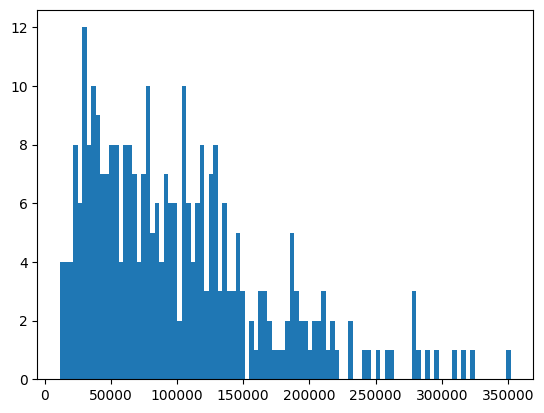

In [163]:
result = []
for i in range(311):
    _, l = audio_processed[i]['input_values'].shape
    result.append(l)
    
plt.hist(result, bins=100)

In [156]:
audio_embedding_3[2]['last_hidden_state'].shape

torch.Size([1, 988, 768])

In [ ]:
result = []
for i in range(311):
    _, l, _ = audio_embedding_3[i]['last_hidden_state'].shape
    result.append(l)
    
plt.hist(result, bins=100)

audio_datasets

In [175]:
audio_datasets[1]['audio'][0]['array']

array([-0.00183105, -0.00146484, -0.00140381, ..., -0.00091553,
       -0.00076294, -0.0010376 ], dtype=float32)

In [172]:
processor(audio_datasets[1]['audio'][0]['array'], sampling_rate = sampling_rate)

{'input_values': [array([-0.07524762, -0.05815899, -0.05531088, ..., -0.03252605,
       -0.02540578, -0.03822226], dtype=float32)], 'attention_mask': [array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]}

(array([ 4.,  4.,  4.,  8.,  7., 11.,  8., 11.,  8., 10.,  5.,  7.,  9.,
         3.,  8.,  8.,  7.,  4.,  7., 10.,  5.,  7.,  3.,  8.,  5.,  6.,
         4.,  8.,  6.,  4.,  7.,  7.,  4.,  7.,  7.,  3.,  6.,  4.,  2.,
         5.,  3.,  0.,  2.,  1.,  3.,  3.,  2.,  1.,  1.,  1.,  2.,  5.,
         3.,  2.,  2.,  1.,  2.,  2.,  3.,  1.,  2.,  1.,  0.,  0.,  2.,
         0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         3.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  36.  ,   46.64,   57.28,   67.92,   78.56,   89.2 ,   99.84,
         110.48,  121.12,  131.76,  142.4 ,  153.04,  163.68,  174.32,
         184.96,  195.6 ,  206.24,  216.88,  227.52,  238.16,  248.8 ,
         259.44,  270.08,  280.72,  291.36,  302.  ,  312.64,  323.28,
         333.92,  344.56,  355.2 ,  365.84,  376.48,  387.12,  397.76,
         408.4 ,  419.04,  429.68,  440.32,  450.96,  461.6 ,  472.24,
        

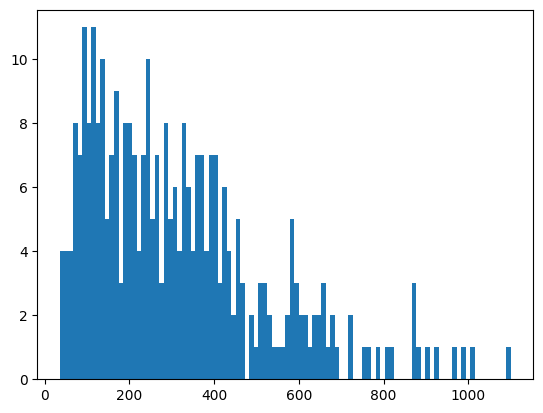

In [157]:
result = []
for i in range(311):
    _, l, _ = audio_embedding_3[i]['last_hidden_state'].shape
    result.append(l)
    
plt.hist(result, bins=100)

In [ ]:
model_inputs = processor(
        processor_inputs, padding=True, return_attention_mask=True, return_tensors="pt")

In [33]:
result = []
for i in range(311):
    a, b, c = audio_outputs[i]['last_hidden_state'].shape
    result.append(b)
    
pd.DataFrame(result).describe()

,0
count,311.00000
mean,315.77492
std,209.48179
min,36.00000
25%,147.00000
50%,273.00000
75%,410.00000
max,1100.00000


(array([79., 69., 59., 46., 27., 18.,  6.,  4.,  2.,  1.]),
 array([ 15. ,  47.5,  80. , 112.5, 145. , 177.5, 210. , 242.5, 275. ,
        307.5, 340. ]),
 <BarContainer object of 10 artists>)

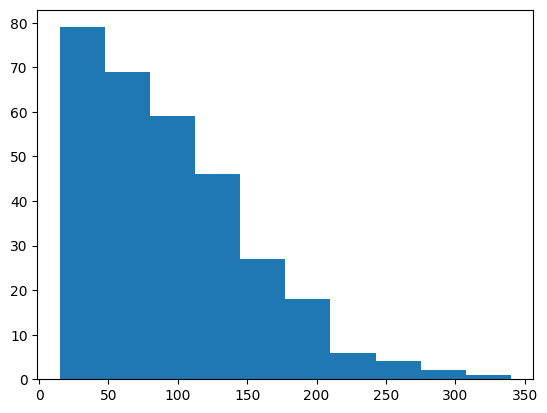

In [42]:
plt.hist(sorted(result), )

In [37]:
result = []
for i in range(311):
    a, b, c = text_outputs[i]['last_hidden_state'].shape
    result.append(b)
    
pd.DataFrame(result).describe()

,0
count,311.000000
mean,94.491961
std,59.196930
min,15.000000
25%,45.500000
50%,81.000000
75%,128.000000
max,340.000000


(array([ 7.,  7., 11.,  7.,  8., 13.,  5.,  5., 10.,  6.,  4.,  6.,  8.,
         7.,  2.,  6., 14.,  6.,  9.,  7., 14.,  6.,  5.,  5.,  4.,  4.,
         4.,  4., 11.,  2.,  5.,  3.,  7.,  5.,  7.,  4.,  5.,  4.,  3.,
         3.,  4.,  3.,  2.,  1.,  3.,  5.,  2.,  3.,  3.,  1.,  2.,  0.,
         1.,  0.,  3.,  6.,  3.,  1.,  1.,  1.,  0.,  1.,  3.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 15.  ,  18.25,  21.5 ,  24.75,  28.  ,  31.25,  34.5 ,  37.75,
         41.  ,  44.25,  47.5 ,  50.75,  54.  ,  57.25,  60.5 ,  63.75,
         67.  ,  70.25,  73.5 ,  76.75,  80.  ,  83.25,  86.5 ,  89.75,
         93.  ,  96.25,  99.5 , 102.75, 106.  , 109.25, 112.5 , 115.75,
        119.  , 122.25, 125.5 , 128.75, 132.  , 135.25, 138.5 , 141.75,
        145.  , 148.25, 151.5 , 154.75, 158.  , 161.25, 164.5 , 167.75,
  

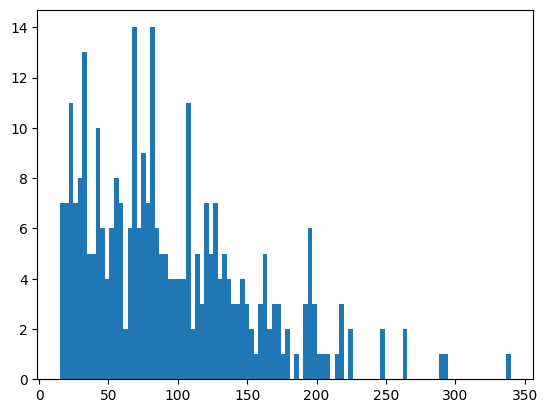

In [38]:
plt.hist(result, bins = 100)

In [55]:
    text_embedding_1 = []
# for i in range(311):
    processed_inputs = tokenizer(text_datasets[1][1][0:4], padding=True, return_attention_mask=True, return_tensors="pt")  
    with torch.no_grad():
        text_output = text_d2v(**processed_inputs)
    text_embedding_1.append(text_output)

In [56]:
    text_embedding_2 = []
# for i in range(311):
    processed_inputs = tokenizer(text_datasets[1][1][4:8], padding=True, return_attention_mask=True, return_tensors="pt")  
    with torch.no_grad():
        text_output = text_d2v(**processed_inputs)
    text_embedding_2.append(text_output)

In [57]:
    text_embedding_3 = []
# for i in range(311):
    processed_inputs = tokenizer(text_datasets[1][1][4:8], padding=True, return_attention_mask=True, return_tensors="pt")  
    with torch.no_grad():
        text_output = text_d2v(**processed_inputs)
    text_embedding_3.append(text_output)

In [62]:
audio_embedding = [audio_embedding_1, audio_embedding_2, audio_embedding_3]
text_embedding = [text_embedding_1, text_embedding_2, text_embedding_3]

In [179]:
# cpu만 사용하면 8분걸림
# cuda를 사용하면 OOM

audio_embedded_dict = audio_embedding(audio_datasets,32)
text_embedded_dict = text_embedding(text_datasets, 32)

100%|██████████| 1/1 [00:18<00:00, 18.84s/it]


In [185]:
audio_embedded_dict[1][0]['last_hidden_state'].shape

torch.Size([32, 49, 768])

In [194]:
# cpu만 사용하다가 커널이 죽었음
# cuda를 사용하면 OOM

text_embedded_dict = text_embedding(text_datasets, 32)

  0%|          | 0/1 [00:00<?, ?it/s]

311


: 

: 

In [118]:
target_dict = make_target_dict(40)
target = target_dict[1]['emotion'][0:4]
target[0:3] = 0
target[3] = 1
# target[4:8] = 0
target = target.astype('float32')
target = target.values
target = torch.tensor(target)

100%|██████████| 40/40 [00:00<00:00, 154.77it/s]


In [ ]:
# a = txt.len
class MLP_2(nn.Module):
    
    def __init__(self):
        super(MLP_2, self).__init__()
        
        self.fc1 = nn.Linear(a * 768, 768)
        self.fc2 = nn.Linear(768, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mlp_2 = MLP_2()

In [ ]:
# a = txt.len
class MLP_3(nn.Module):
    
    def __init__(self):
        super(MLP_2, self).__init__()
        
        self.fc1 = nn.Linear(b * 768, 768)
        self.fc2 = nn.Linear(768, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mlp_2 = MLP_2()

In [38]:
class MLP_1(nn.Module):
    
    def __init__(self):
        super(MLP_1, self).__init__()
        
        self.fc1 = nn.Linear(1235 * 768, 768)
        self.fc2 = nn.Linear(768, 2)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mlp_1 = MLP_1()

In [ ]:
# 차원 축소를 무조건 수행해야 할 것. 

class MLP_2(nn.Module):
    
    def __init__(self):
        super(MLP_2, self).__init__()
        
        self.fc1 = nn.Linear(988 * 247 * 768, 768)
        self.fc2 = nn.Linear(768, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mlp_2 = MLP_2()

In [ ]:
# a = txt.len
class MLP_1(nn.Module):
    
    def __init__(self):
        super(MLP_1, self).__init__()
        
        self.fc1 = nn.Linear(a * 768, 768)
        self.fc2 = nn.Linear(768, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
mlp_2 = MLP_2()

In [74]:
text_embedding

[[BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2201, -0.0666,  0.0060,  ..., -0.0497, -0.1140,  0.1118],
           [-0.0825, -0.1271, -0.0981,  ..., -0.0238,  0.1167,  0.0750],
           [-0.0827, -0.1283, -0.0996,  ..., -0.0240,  0.1175,  0.0731],
           ...,
           [-0.0175, -0.0055, -0.0603,  ...,  0.0140, -0.1443,  0.1085],
           [-0.0175, -0.0055, -0.0603,  ...,  0.0140, -0.1443,  0.1085],
           [-0.0175, -0.0055, -0.0603,  ...,  0.0140, -0.1443,  0.1085]],
  
          [[ 0.2213, -0.0926,  0.0161,  ..., -0.0221, -0.0915,  0.1040],
           [-0.0858, -0.1488, -0.1290,  ..., -0.0294,  0.0905,  0.0782],
           [-0.0866, -0.1474, -0.1287,  ..., -0.0289,  0.0938,  0.0791],
           ...,
           [ 0.0723, -0.0225, -0.0495,  ...,  0.0341, -0.1373,  0.1264],
           [ 0.0723, -0.0225, -0.0495,  ...,  0.0341, -0.1373,  0.1264],
           [ 0.0723, -0.0225, -0.0495,  ...,  0.0341, -0.1373,  0.1264]],
  
          [[ 0.1490, 

In [75]:
a = [audio_embedding, text_embedding]

In [95]:
a[0][0]

[Wav2Vec2BaseModelOutput(last_hidden_state=tensor([[[-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6787e-03,
           -7.2099e-02,  2.8462e-01],
          [-1.1453e+00, -1.3806e-01, -6.6732e-02,  ...,  6.6784e-03,
           -7.2098e-02,  2.8462e-01],
          [-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6792e-03,
           -7.2098e-02,  2.8462e-01],
          ...,
          [-9.0208e-01, -6.1873e-02, -4.0272e-02,  ..., -1.4839e-01,
           -1.7549e-01,  1.7050e-01],
          [-9.0822e-01, -5.7904e-02, -4.5461e-02,  ..., -1.5357e-01,
           -1.8189e-01,  1.7206e-01],
          [-9.1004e-01, -5.6092e-02, -4.8181e-02,  ..., -1.5627e-01,
           -1.8337e-01,  1.7411e-01]],
 
         [[-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
           -7.7794e-04,  4.8156e-01],
          [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4447e-02,
           -7.7803e-04,  4.8156e-01],
          [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
           -7.7

In [93]:
audio_embedding[1][0]['last_hidden_state'].shape

torch.Size([4, 500, 768])

In [72]:
class Dynamic_Mlp(nn.Module):
    
    def __init__(self, input, target):
        super(Dynamic_Mlp, self).__init__()
        self.input = input
        self.audio_input = self.input[0]
        self.text_input = self.input[1]
        self.iteration = len(self.audio_input)
        self.target = target
        

        b, w, d = self.input.shape
        self.fc1 = nn.Linear(w * d, 768)
        self.rangex = []
        self.rangex.append((w, d))
        self.fcx = []
        
        self.fc2 = nn.Linear(768, 1)
        
    def forward(self, x):
        
        for i in range(self.iteration):
            
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
dynamic_mlp = Dynamic_Mlp()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Dynamic_Mlp.parameters(), lr=0.01)

num_epochs = 3
batch_size = 4

TypeError: Dynamic_Mlp.__init__() missing 1 required positional argument: 'input'

In [ ]:
epoch_loss = 0
for epoch in range(num_epochs):
    
    inputs = audio_embedding[i]
    targets = target.long()[i * 4 : (i + 1) * 4]
    
    (b, w, d) = inputs.shape
    
    running_loss = 0.0

    outputs = Dynamic_Mlp(inputs)
        
    loss = criterion(outputs, targets)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    running_loss += loss.item() * batch_size
        
    epoch_loss = running_loss / num_samples
    print("Epoch {}, Loss: {}".format(epoch+1, epoch_loss))
        

In [132]:
shape = (4, 1235 , 768)
x_train = torch.rand(shape)
y_train = target

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_1.parameters(), lr=0.01)

num_epochs = 2
batch_size = 1
num_samples = x_train.shape[0]

In [111]:
a[0][0][0]['last_hidden_state']

tensor([[[-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6787e-03,
          -7.2099e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6732e-02,  ...,  6.6784e-03,
          -7.2098e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6792e-03,
          -7.2098e-02,  2.8462e-01],
         ...,
         [-9.0208e-01, -6.1873e-02, -4.0272e-02,  ..., -1.4839e-01,
          -1.7549e-01,  1.7050e-01],
         [-9.0822e-01, -5.7904e-02, -4.5461e-02,  ..., -1.5357e-01,
          -1.8189e-01,  1.7206e-01],
         [-9.1004e-01, -5.6092e-02, -4.8181e-02,  ..., -1.5627e-01,
          -1.8337e-01,  1.7411e-01]],

        [[-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7794e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4447e-02,
          -7.7803e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7759e-04,  4.8156e-01],
         ...,
         [-1.0012e+00,  4

In [116]:
torch.concat((a[0][0][0]['last_hidden_state'], a[0][1][0]['last_hidden_state']), dim=1)

tensor([[[-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6787e-03,
          -7.2099e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6732e-02,  ...,  6.6784e-03,
          -7.2098e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6792e-03,
          -7.2098e-02,  2.8462e-01],
         ...,
         [-9.3663e-01, -5.5293e-02, -6.8097e-02,  ..., -1.5364e-01,
          -1.4114e-01,  3.0419e-01],
         [-9.3495e-01, -5.3199e-02, -6.8471e-02,  ..., -1.5613e-01,
          -1.4451e-01,  3.0472e-01],
         [-9.3474e-01, -5.6793e-02, -6.9754e-02,  ..., -1.5615e-01,
          -1.4653e-01,  3.0076e-01]],

        [[-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7794e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4447e-02,
          -7.7803e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7759e-04,  4.8156e-01],
         ...,
         [-6.7408e-01, -1

In [119]:
target.long()

tensor([0, 0, 0, 1])

In [123]:
x_train = torch.tensor(torch.concat((a[0][0][0]['last_hidden_state'], a[0][1][0]['last_hidden_state']), dim=1))
y_train = target.long()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

num_epochs = 2
batch_size = 1
num_samples = x_train.shape[0]

/tmp/ipykernel_758714/3510190268.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(torch.concat((a[0][0][0]['last_hidden_state'], a[0][1][0]['last_hidden_state']), dim=1))


In [101]:
a[0][0]

3

In [102]:
len(a[1])

3

In [122]:
x_train = torch.tensor(a[0][0], text_outputs['last_hidden_state']), dim=1
y_train = target

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

num_epochs = 2
batch_size = 1
num_samples = x_train.shape[0]

SyntaxError: unmatched ')' (3127040863.py, line 1)

In [127]:
epoch_loss = 0
for epoch in range(num_epochs):
    
    running_loss = 0.0
    for i in range(0, num_samples, batch_size):
        print(i)
        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        outputs = net(inputs)
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_size
        
    epoch_loss = running_loss / num_samples
    print("Epoch {}, Loss: {}".format(epoch+1, epoch_loss))
        

0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1142784 and 120x84)

In [49]:
49 * 768

37632

In [ ]:
16 * 62976 / 37632 * 768

In [19]:
epoch_loss

1.125643518555141e+19

In [63]:
x_train = torch.randint(0, 1, (1,120))
y_train = torch.randint(0, 1, (1,10))

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

num_epochs = 5
batch_size = 1
num_samples = x_train.shape[0]

NameError: name 'net' is not defined

In [126]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
                          
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [67]:
net(x_train)

RuntimeError: mat1 and mat2 must have the same dtype

In [68]:
# 모델 정의
class SimpleModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 데이터셋 생성
x_train = torch.randn((30, 10))
y_train = torch.randn((30, 5))

# 하이퍼파라미터 설정
input_dim = x_train.shape[1]
hidden_dim = 20
output_dim = y_train.shape[1]
lr = 0.01
num_epochs = 3
batch_size = 5

# 모델 초기화
model = SimpleModel(input_dim, hidden_dim, output_dim)

# 손실함수 정의
criterion = nn.MSELoss()

# 옵티마이저 정의
optimizer = optim.SGD(model.parameters(), lr=lr)

# 훈련
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, num_samples, batch_size):
        # 배치 데이터 로드
        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 손실값 누적
        running_loss += loss.item() * batch_size
    
    # 에폭별 손실값 출력
    print('Epoch {} Loss: {:.4f}'.format(epoch+1, running_loss/num_samples))

Epoch 1 Loss: 0.8839
Epoch 2 Loss: 0.8758
Epoch 3 Loss: 0.8678


In [71]:
x_train

tensor([[[-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6787e-03,
          -7.2099e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6732e-02,  ...,  6.6784e-03,
          -7.2098e-02,  2.8462e-01],
         [-1.1453e+00, -1.3806e-01, -6.6733e-02,  ...,  6.6792e-03,
          -7.2098e-02,  2.8462e-01],
         ...,
         [-1.7483e-02, -5.4983e-03, -6.0314e-02,  ...,  1.3965e-02,
          -1.4430e-01,  1.0852e-01],
         [-1.7483e-02, -5.4983e-03, -6.0314e-02,  ...,  1.3965e-02,
          -1.4430e-01,  1.0852e-01],
         [-1.7483e-02, -5.4984e-03, -6.0314e-02,  ...,  1.3965e-02,
          -1.4430e-01,  1.0852e-01]],

        [[-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7794e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4447e-02,
          -7.7803e-04,  4.8156e-01],
         [-9.5902e-01, -6.7264e-02, -2.1643e-01,  ...,  9.4446e-02,
          -7.7759e-04,  4.8156e-01],
         ...,
         [ 7.2260e-02, -2

In [69]:
x_train

tensor([[ 0.7589, -0.2451,  0.3043, -1.1257, -0.7017, -0.5993,  1.4000,  0.9494,
         -0.0170, -0.0424],
        [-0.8227,  0.0786, -0.7696,  0.7970,  2.1975,  0.3471,  0.3051, -1.5030,
          1.1239,  0.3276],
        [ 1.1657, -0.7739,  1.4156, -1.7199,  1.0934,  0.5445, -0.7570, -1.4942,
         -1.0362,  0.5432],
        [-0.2782, -1.2190,  1.0431,  0.0808, -0.1665,  0.7406, -1.2880,  0.7423,
          0.8216,  1.6441],
        [ 0.3207,  0.8375,  0.5336,  1.1942,  0.5790,  0.2433, -1.0244, -0.9470,
         -0.0452, -0.8878],
        [ 0.8417,  0.2664,  0.5194,  0.7736, -1.3530, -1.0820,  0.6434, -0.9518,
         -0.4851, -0.5505],
        [ 0.1473,  2.3938, -0.8641,  0.2462,  0.0651,  0.2549, -0.9982, -0.8814,
         -0.0098,  1.5151],
        [ 0.5930, -0.8168, -0.8172, -0.1530,  0.0569,  0.6663, -0.3458, -1.2687,
         -0.3133, -0.4569],
        [-0.9944, -0.7339, -0.1201, -0.6393,  0.7754, -1.3064, -0.4372, -0.0418,
         -0.4973, -0.1493],
        [-0.4678, -